Importing libaries and setting out and defining the algerbraic symbols used in the analytic part of the code.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import gamma

INITIAL_RANGE_PARAMETER = 0.001 # In [fm^-2]
BETA = 0.1 # In [fm^-2], can be edited to get a better fit for a realistic density distrbution.
REDUCED_MASS = 846.8 # In [units], need to update value and units (10/11 A in MeV)
SUM_LIMIT = 100 # Determines the number of gaussians we expand our wave function to
XVALS = 300 # number of x values to plot in our plot of u(r)

MIXING_COEFFICIENTS = [-2.20325082, 8.805878, -156.81065165, 103.98341216, -1.56877559, -30.53077774,
                       32.26066114, -27.54625751, 20.71335292, -13.61817415, 6.70243229, -1.89204065]
POTENTIAL_PARAMETERS = [5.000e-02, 1.000e-01, 2.000e-01, 4.000e-01, 8.000e-01, 1.600e+00, 3.200e+00,
                        6.400e+00, 1.280e+01, 2.560e+01, 5.120e+01, 1.024e+02]


We now want to start defining our key functions that describe relevent parts of the system

In [16]:
def single_gaussian_potential_function(r, c, β):
    """
    Defines the form of the Gaussian wavefunctions used in the series expansion of the wavefunction in terms of the radius r,
    the orbital angular momentum, l, and a range parameter, α_i.
    Handles odd, even, and l=0 cases sepratley to ensure the normalisation factor is correct.

    Parameters
    ----------
    r : sympy variable
    β : float, parameter characterising the gaussian
    c : float, mixing coefficient determining the gaussian fits

    Returns
    -------
    expression evaluated at r, array like 
    """
    return c * np.exp(-β * (r)**2)


def gaussian_expanded_potential(radius, mixing_coefficients=MIXING_COEFFICIENTS, potential_parameters=POTENTIAL_PARAMETERS):
    potential = 0
    for i in range(len(MIXING_COEFFICIENTS)):
        potential += single_gaussian_potential_function(radius, mixing_coefficients[i], potential_parameters[i])
    return potential


def gaussian_wavefunction(radius, range_parameter, orb_ang_momentum):
    return radius**(orb_ang_momentum) * np.exp(-range_parameter * radius**2)

We have used mathmatica to get a set of analytical expressions for our matrix elements, defined here

In [17]:
def overlap_matrix_element(orb_ang_momentum, range_param_i, range_param_j):
    return 0.5 * (range_param_i + range_param_j)**(-0.5 - orb_ang_momentum) * gamma(0.5 + orb_ang_momentum)

def potential_matrix_element(orb_ang_momentum, range_param_i, range_param_j, potential_mixing_coefficient, potential_param):
    return 0.5 * potential_mixing_coefficient *  (range_param_i + range_param_j+ potential_param)**(
        -0.5 - orb_ang_momentum) * gamma(0.5 + orb_ang_momentum)

def kinetic_matrix_element(orb_ang_momentum, range_param_i, range_param_j, μ=REDUCED_MASS):
    differential_term = -0.5 * (range_param_i + range_param_j)**(-1.5 - orb_ang_momentum) * (
        orb_ang_momentum**2 * (range_param_i - range_param_j)**2 + range_param_i*range_param_j
        - orb_ang_momentum * (range_param_i + range_param_j)**2) * gamma(-0.5 + orb_ang_momentum)
    centrifugal_term = 0.5 * (range_param_i + range_param_j)**(0.5 - orb_ang_momentum) * gamma(-0.5 + orb_ang_momentum) * (
        orb_ang_momentum * (orb_ang_momentum + 1))
    return (197 / (2 * μ)) * differential_term * centrifugal_term

Using these we can now generate our matricies to be solved, taking care to iterate over all of our potential gaussians.

In [18]:
def matrix_generation(orb_ang_momentum, potential_mixing_coefficients=MIXING_COEFFICIENTS,
                      potential_parameters=POTENTIAL_PARAMETERS, size=SUM_LIMIT):
    h_matrix = np.zeros(shape=(size, size))
    n_matrix = np.zeros(shape=(size, size))
    i = 0 # these count the elements of the matricies created
    j = 0

    while i < size:
        i_range_parameter = next_range_parameter(i)
        while j < size:
            j_range_parameter = next_range_parameter(j)
            kinetic_energy_term = kinetic_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter)
            potential_energy_term = 0
            for k in range(len(MIXING_COEFFICIENTS)):
                potential_energy_term += potential_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter,
                                                                 potential_mixing_coefficients[k],
                                                                 potential_parameters[k])
            h_matrix[i, j] = kinetic_energy_term + potential_energy_term
            h_matrix[j, i] = h_matrix[i, j]
            n_matrix[i, j] = overlap_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter)
            n_matrix[j, i] = n_matrix[i, j]
            if i == 4 and j == 13:
                print(h_matrix[j, i])
            elif i == 7 and j == 21:
                print(h_matrix[j, i])
            elif i == 19 and j == 42:
                print(h_matrix[j, i])
            elif i == 28 and j == 30:
                print(h_matrix[j, i])
            j += 1
        i += 1
        # print('row', i, 'column', j, 'complete')
        j = i

    return h_matrix, n_matrix


def next_range_parameter(i, initial_range_parameter=INITIAL_RANGE_PARAMETER, geometric_progression_number=2):
    """
    Finds the next range parameter given the previous and initial range parameters.
    Currently using a simple geometric series to determine range parameters.
    Chose geometric basis parameters $\alpha_i = \alpha_1a^{i-1}$ with initial parameters $\alpha_1 = 0.01, a=2$

    Parameters
    ----------
    i : int detailing the iteration number

    Returns
    -------
    new_range_parameter: float

    """
    new_range_parameter = initial_range_parameter * geometric_progression_number**(i)
    return new_range_parameter

We now generate and then save the matrices to csv files to save having to use the computation time to rerun them every time we restart the code.

In [19]:
orbital_quantum_number = 0
h_matrix, n_matrix = matrix_generation(orbital_quantum_number)
np.savetxt('s_state_h_matrix.csv', h_matrix, delimiter=',')
np.savetxt('s_state_n_matrix.csv', n_matrix, delimiter=',')

-18.973746211228836
-1.1938745846119623
-0.0008245740682819355
-0.047201363572523344


With our matrices found we now calculate the eigenvalues and the groundstate eigenvector, corresponding to the lowest (hence groundstate) energy.

In [20]:
eigenvalues, eigenvectors = scipy.linalg.eigh(h_matrix, n_matrix)
ground_state_eigenvector = np.asmatrix(eigenvectors[:, 0])
print("The eigenvalues are", eigenvalues)
print("The groundstate eigenvector is", ground_state_eigenvector)

The eigenvalues are [-6.17041916e+01 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01
 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01
 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01
 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01
 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01
 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01
 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01
 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01
 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01
 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01
 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01
 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01
 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01
 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01
 -6.17041916e+01 -6.17041916e+01 -6.17041916e+01 -6.17041915e+01
 -6.1

a

In [21]:
normalisation_check = ground_state_eigenvector * n_matrix * np.transpose(ground_state_eigenvector)
print("normalisation = ", normalisation_check[0, 0])

normalisation =  0.9999999999924611


With our normalised groundstate eigenvector we have the coeffffficients of our expansion terms. With these we get our terms in the expasion of u(r) as a set of gaussians (solved numerically rather than as an sympy expression)

In [24]:
def reduced_radial_wavefunction(x_values, orbital_quantum_number, sum_limit=SUM_LIMIT, xvals = XVALS):
    """
    Defines a numerical method of finding the reduced radial wavefunction as a sum of our gaussians.
    """
    range_parameter_array = np.zeros(shape=(1, sum_limit))
    for i in range(sum_limit):
        range_parameter_array[0, i] = next_range_parameter(i)

    temp = 0
    for i in range(xvals):
        for j in range(sum_limit):
            temp += ground_state_eigenvector[0, j] * gaussian_wavefunction(x_values, range_parameter_array[0, j], orbital_quantum_number)
        temp = temp**2
    return temp

C:\Users\faola\AppData\Local\Temp\ipykernel_9192\675864424.py:13: RuntimeWarning: overflow encountered in square
  temp = temp**2


ValueError: x and y must have same first dimension, but have shapes (300,) and (1,)

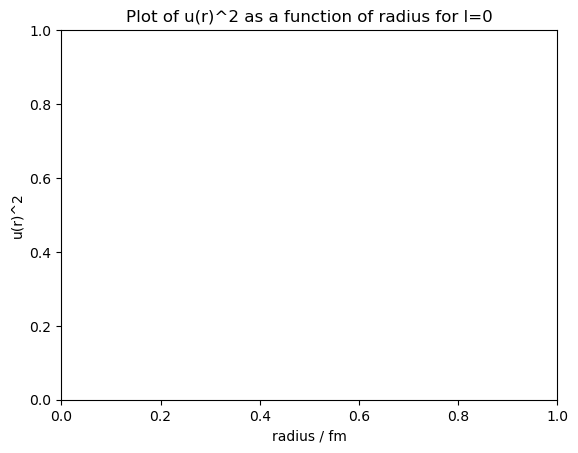

In [25]:
fig = plt.figure()
ax = fig.add_subplot()

x_values = np.linspace(0., 15, XVALS)
evaluated_ur_values = reduced_radial_wavefunction(x_values, 0)[0]
#print(reduced_radial_wavefunction(x_values))

ax.set_title('Plot of u(r)^2 as a function of radius for l=0')
ax.set_xlabel('radius / fm')
ax.set_ylabel('u(r)^2')
ax.plot(x_values, evaluated_ur_values)

plt.savefig('s_state_plot.png', dpi=300)
plt.show()

i


C:\Users\faola\AppData\Local\Temp\ipykernel_18948\1909541734.py:62: RuntimeWarning: invalid value encountered in log
  ax_2.plot(X_vals, np.log(gaussian_potential_plot(X_vals, 0)), label = '12 gaussians')


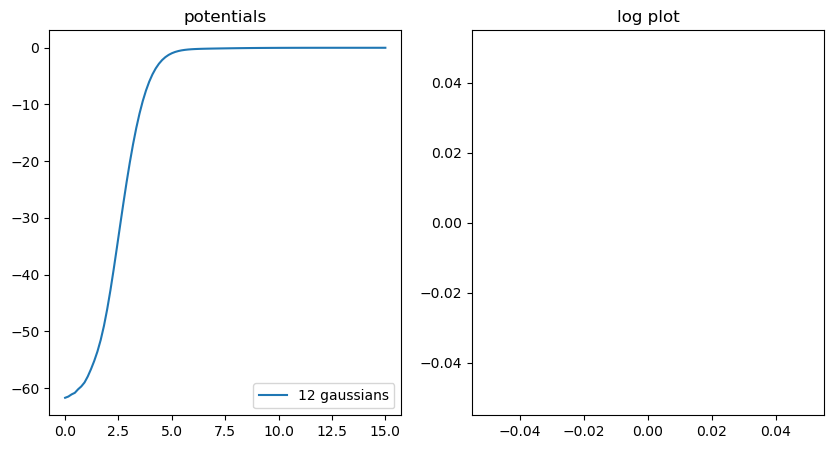

In [22]:
fig = plt.figure(figsize = (10,5))
X_vals = np.linspace(0.0000000000001, 15, 100)

def single_gaussian_potential_function_plot(radius, c, β):
    """
    Defines the form of the Gaussian wavefunctions used in the series expansion of the wavefunction in terms of the radius r,
    the orbital angular momentum, l, and a range parameter, α_i.
    Handles odd, even, and l=0 cases sepratley to ensure the normalisation factor is correct.

    Parameters
    ----------
    r : sympy variable
    β : float, parameter characterising the gaussian
    c : float, mixing coefficient determining the gaussian fits

    Returns
    -------
    sympy expression
    """
    return c * np.exp(-β * (radius)**2)

def gaussian_potential_plot(radius, l, mixing_coefficients=MIXING_COEFFICIENTS, potential_parameters=POTENTIAL_PARAMETERS):
    """
    Defines the spherically symmetric gaussian potential as a function of radius we use as a 'first guess'
    to make our integrals analytic. Given as V = V_0 * e**(-beta * radius**2)

    Parameters
    ----------
    radius : float
    parameters : 1d array containg the fixed parameters for our potential. In the order [V_0, beta] (see slides/supplimentary notes) 

    Returns
    -------
    float with the value of the potential at a radius r

    """
    V_0 = -11.39 * (-1)**l - 51.13 # Defines V_0 for odd and even l states
    return (single_gaussian_potential_function_plot(radius, mixing_coefficients[0], potential_parameters[0])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[1], potential_parameters[1]) 
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[2], potential_parameters[2])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[3], potential_parameters[3])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[4], potential_parameters[4])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[5], potential_parameters[5])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[6], potential_parameters[6])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[7], potential_parameters[7])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[8], potential_parameters[8])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[9], potential_parameters[9])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[10], potential_parameters[10])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[11], potential_parameters[11])
        
    )

spec = fig.add_gridspec(ncols=2, nrows=1)
ax_1 = fig.add_subplot(spec[0, 0])
ax_2 = fig.add_subplot(spec[0, 1])

ax_1.plot(X_vals, gaussian_potential_plot(X_vals, 0), label = '12 gaussians')
ax_1.legend()
ax_1.set_title('potentials')
print('i')

ax_2.plot(X_vals, np.log(gaussian_potential_plot(X_vals, 0)), label = '12 gaussians')
ax_2.set_title('log plot')

plt.show()